In [2]:
# resource:
## logistic regression: https://www.kaggle.com/code/sachinsom/sign-prediction-using-pytorch#Logistic-regression

In [3]:
#! pip install torch
#! pip install torchvision
#! pip install seaborn
#! pip install torchmetrics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#load data, data is image represented by numpy array and labels is their relative labels
with np.load('train_data_label.npz') as data:
    train_data = data['train_data']
    train_labels = data['train_label']

with np.load('test_data_label.npz') as data:
    test_data = data['test_data']
    test_labels = data['test_label']

In [7]:
#check data shape
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)
train_data = train_data.astype('float32')
test_data  = test_data.astype('float32')

(27455, 784) (27455,) (7172, 784) (7172,)


In [8]:
#reshape the data, thus an image is represented by a 28 x 28 array
scaler = StandardScaler()
train_images_shaped = train_data.reshape(train_data.shape[0],1,28,28)
test_images_shaped = test_data.reshape(test_data.shape[0],1,28,28)

train_images_scaled = scaler.fit_transform(train_images_shaped.reshape(-1,train_images_shaped.shape[-1])).reshape(train_images_shaped.shape)
test_images_scaled = scaler.transform(test_images_shaped.reshape(-1,test_images_shaped.shape[-1])).reshape(test_images_shaped.shape)

In [9]:
#check shape
print(train_images_scaled.shape, train_labels.shape, test_images_scaled.shape, test_labels.shape)

(27455, 1, 28, 28) (27455,) (7172, 1, 28, 28) (7172,)


In [10]:
#turn numpy array into pytorch tensors
train_images_tensors = torch.from_numpy(train_images_scaled)
train_labels_tensors = torch.from_numpy(train_labels)

test_images_tensors = torch.from_numpy(test_images_scaled)
test_labels_tensors = torch.from_numpy(test_labels)

In [11]:
# pytorch dataset
#this dataset will further devided into validation dataset and training dataset
train_ds_full = TensorDataset(train_images_tensors, train_labels_tensors)
#for prediction
test_ds = TensorDataset(test_images_tensors, test_labels_tensors)

In [12]:
# each image is converted to a (1, 28, 28)
# The first dimension is for the number of channels.
# The second and third dimensions are for the size of the image, in this case, 28px by 28px.

img, label = train_ds_full[0]
print(img.shape, label)
img.type()

torch.Size([1, 28, 28]) tensor(3)


'torch.FloatTensor'

In [13]:
# Hyperparmeters
# batch_size = 64   #baseline model
# learning_rate = 0.001  #baseline model

# Other constants
in_channels = 1
input_size = in_channels * 28 * 28
num_classes = 26

In [14]:
# split dataset to training, validation, testing sets
random_seed = 11
torch.manual_seed(random_seed);

In [15]:
val_size = 7455
train_size = len(train_ds_full) - val_size

train_ds, val_ds = random_split(train_ds_full, [train_size, val_size,])
len(train_ds), len(val_ds), len(test_ds)

(20000, 7455, 7172)

In [16]:
# model 1, with batch size 32; will use lr = 0.001, epoch = 50
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size = 32, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size = 32, num_workers=4, pin_memory=True)

In [17]:
#check data size for one batch 
for img, label in train_dl:
    print(img.size())
    break

torch.Size([32, 1, 28, 28])


In [18]:
# model 2, with batch size 64; will use lr = 0.001, epoch = 50
train_dl2 = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dl2 = DataLoader(val_ds, batch_size=64, num_workers=4, pin_memory=True)
test_dl2 = DataLoader(test_ds, batch_size=64, num_workers=4, pin_memory=True)

In [19]:
# model 3, with batch size 32; will use lr = 0.0001, epoch = 50
train_dl3 = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_dl3 = DataLoader(val_ds, batch_size=32, num_workers=4, pin_memory=True)
test_dl3 = DataLoader(test_ds, batch_size=32, num_workers=4, pin_memory=True)

In [20]:
# Logistic Regression Model
class ASLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, in_channels*28*28)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = ASLModel()

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [22]:
#attempt 1, the accuracy function seems not right (it's sensitivity)

def sen_per_class(outputs, labels, model, test_dl):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return (confusion_matrix.diag()/confusion_matrix.sum(1))

In [23]:
# attemp 2, seems right (i decide to use sensitivity now because accuracy per class is so high even before training)

def sensitivity_per_class(outputs, labels, test_dl):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    cm = confusion_matrix.numpy()

    for i in range(cm.shape[0]):
        TP = cm[i,i]
        FP = cm.sum(axis=0)[i] - TP
        FN = cm.sum(axis=1)[i] - TP
        TN = cm.sum()- (FP + FN + TP)
        sens = ((TP)/(TP+FN))
        print('label: {}, Sensitivity : {}'.format(i, sens))
    return

In [24]:
#check the dataset before training in baseline model
for images, labels in test_dl:
    outputs = model(images)
    print(labels)
    print(accuracy(outputs, labels))
    
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

tensor([ 6,  5, 10,  0,  3, 21, 10, 14,  3,  7,  8,  8, 21, 12,  7,  4, 22,  0,
         7,  7,  2,  0, 21,  4, 10, 15,  2, 15,  7,  1,  7,  8])
tensor(0.)
outputs.shape :  torch.Size([32, 26])
Sample outputs :
 tensor([[ 9.8361e-01, -7.5713e-01,  9.5846e-01,  7.5101e-01, -8.9864e-01,
          3.2005e-01,  8.3344e-03,  2.2606e-01, -6.5728e-01,  1.1270e-01,
          2.4632e-01,  1.1514e-01, -6.0882e-01,  1.7807e-01, -3.0856e-01,
         -4.7066e-01, -1.0198e+00, -1.2108e+00,  5.4845e-01,  3.0468e-01,
         -1.5922e-01, -1.6064e+00,  2.6649e-01, -2.8990e-01, -7.1176e-01,
          8.6573e-02],
        [ 1.9499e-01, -4.5998e-01,  1.5875e-01, -2.0782e-01, -9.1403e-01,
         -3.7418e-01, -1.0083e-03,  8.4247e-02, -3.9199e-02,  4.3206e-01,
          1.5678e-01,  3.6814e-01, -6.9095e-01,  7.2116e-01, -2.7948e-01,
         -1.1002e-01, -1.1390e-02, -3.3763e-01,  3.8621e-01, -3.1186e-01,
          1.5026e-01, -6.0765e-02, -3.8628e-01, -3.6549e-01, -4.6185e-02,
          9.9633e-03]])


In [25]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
model1 = ASLModel()
model2 = ASLModel()
model3 = ASLModel()

In [27]:
result_m1_0 = evaluate(model1, val_dl)
result_m2_0 = evaluate(model2, val_dl2)
result_m3_0 = evaluate(model3, val_dl3)
print(result_m1_0, result_m2_0, result_m3_0)

{'val_loss': 3.4209494590759277, 'val_acc': 0.03232728689908981} {'val_loss': 3.4332754611968994, 'val_acc': 0.034321580082178116} {'val_loss': 3.514925003051758, 'val_acc': 0.026962481439113617}


In [28]:
# model 1
history_m1 = fit(50, 0.001, model1, train_dl, val_dl)

Epoch [0], val_loss: 2.1041, val_acc: 0.4664
Epoch [1], val_loss: 1.6977, val_acc: 0.6019
Epoch [2], val_loss: 1.4739, val_acc: 0.6585
Epoch [3], val_loss: 1.3248, val_acc: 0.6896
Epoch [4], val_loss: 1.2149, val_acc: 0.7206
Epoch [5], val_loss: 1.1300, val_acc: 0.7396
Epoch [6], val_loss: 1.0611, val_acc: 0.7619
Epoch [7], val_loss: 1.0037, val_acc: 0.7773
Epoch [8], val_loss: 0.9543, val_acc: 0.7969
Epoch [9], val_loss: 0.9126, val_acc: 0.8078
Epoch [10], val_loss: 0.8749, val_acc: 0.8189
Epoch [11], val_loss: 0.8412, val_acc: 0.8271
Epoch [12], val_loss: 0.8114, val_acc: 0.8339
Epoch [13], val_loss: 0.7840, val_acc: 0.8406
Epoch [14], val_loss: 0.7596, val_acc: 0.8451
Epoch [15], val_loss: 0.7367, val_acc: 0.8504
Epoch [16], val_loss: 0.7157, val_acc: 0.8553
Epoch [17], val_loss: 0.6955, val_acc: 0.8632
Epoch [18], val_loss: 0.6772, val_acc: 0.8665
Epoch [19], val_loss: 0.6603, val_acc: 0.8712
Epoch [20], val_loss: 0.6438, val_acc: 0.8761
Epoch [21], val_loss: 0.6287, val_acc: 0.880

In [29]:
sen_m1 = sen_per_class(outputs, labels, model1, test_dl)

In [30]:
# model 2
# Let's change dataset to the one with batch size 16, keep the learning rate and look at the results
history_m2 = fit(50, 0.001, model2, train_dl2, val_dl2)

Epoch [0], val_loss: 2.4948, val_acc: 0.3309
Epoch [1], val_loss: 2.1090, val_acc: 0.4591
Epoch [2], val_loss: 1.8699, val_acc: 0.5433
Epoch [3], val_loss: 1.7027, val_acc: 0.5904
Epoch [4], val_loss: 1.5786, val_acc: 0.6210
Epoch [5], val_loss: 1.4802, val_acc: 0.6489
Epoch [6], val_loss: 1.4002, val_acc: 0.6723
Epoch [7], val_loss: 1.3319, val_acc: 0.6954
Epoch [8], val_loss: 1.2739, val_acc: 0.7103
Epoch [9], val_loss: 1.2232, val_acc: 0.7221
Epoch [10], val_loss: 1.1785, val_acc: 0.7334
Epoch [11], val_loss: 1.1384, val_acc: 0.7434
Epoch [12], val_loss: 1.1021, val_acc: 0.7516
Epoch [13], val_loss: 1.0697, val_acc: 0.7574
Epoch [14], val_loss: 1.0394, val_acc: 0.7672
Epoch [15], val_loss: 1.0115, val_acc: 0.7772
Epoch [16], val_loss: 0.9861, val_acc: 0.7859
Epoch [17], val_loss: 0.9624, val_acc: 0.7924
Epoch [18], val_loss: 0.9404, val_acc: 0.7982
Epoch [19], val_loss: 0.9197, val_acc: 0.8050
Epoch [20], val_loss: 0.9002, val_acc: 0.8078
Epoch [21], val_loss: 0.8816, val_acc: 0.813

In [31]:
sen_m2 = sen_per_class(outputs, labels, model2, test_dl)

In [55]:
# model 3
history_m3 = fit(20, 0.001, model3, train_dl3, val_dl3)

Epoch [0], val_loss: 2.1301, val_acc: 0.4558
Epoch [1], val_loss: 1.7132, val_acc: 0.5953
Epoch [2], val_loss: 1.4846, val_acc: 0.6516
Epoch [3], val_loss: 1.3355, val_acc: 0.6879
Epoch [4], val_loss: 1.2247, val_acc: 0.7150
Epoch [5], val_loss: 1.1388, val_acc: 0.7374
Epoch [6], val_loss: 1.0698, val_acc: 0.7547
Epoch [7], val_loss: 1.0117, val_acc: 0.7734
Epoch [8], val_loss: 0.9623, val_acc: 0.7895
Epoch [9], val_loss: 0.9189, val_acc: 0.8028
Epoch [10], val_loss: 0.8813, val_acc: 0.8126
Epoch [11], val_loss: 0.8478, val_acc: 0.8213
Epoch [12], val_loss: 0.8177, val_acc: 0.8321
Epoch [13], val_loss: 0.7905, val_acc: 0.8380
Epoch [14], val_loss: 0.7646, val_acc: 0.8455
Epoch [15], val_loss: 0.7418, val_acc: 0.8504
Epoch [16], val_loss: 0.7202, val_acc: 0.8571
Epoch [17], val_loss: 0.7007, val_acc: 0.8628
Epoch [18], val_loss: 0.6821, val_acc: 0.8680
Epoch [19], val_loss: 0.6642, val_acc: 0.8722


In [56]:
sen_m3 = sen_per_class(outputs, labels, model3, test_dl)

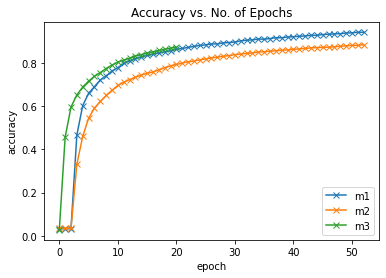

In [57]:
history_m1 = [result_m1_0] + history_m1
history_m2 = [result_m2_0] + history_m2
history_m3 = [result_m3_0] + history_m3
accuracies_m1 = [result['val_acc'] for result in history_m1]
accuracies_m2 = [result['val_acc'] for result in history_m2]
accuracies_m3 = [result['val_acc'] for result in history_m3]
plt.plot(accuracies_m1, '-x', label= 'm1')
plt.plot(accuracies_m2, '-x', label = 'm2')
plt.plot(accuracies_m3, '-x', label = 'm3')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs. No. of Epochs');

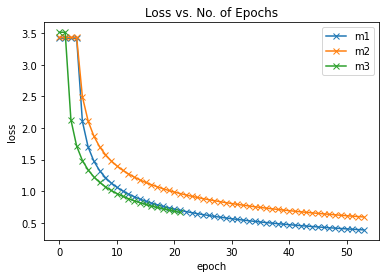

In [58]:
#loss function is cross_entropy
history_m1 = [result_m1_0] + history_m1
history_m2 = [result_m2_0] + history_m2
history_m3 = [result_m3_0] + history_m3
loss_m1 = [result['val_loss'] for result in history_m1]
loss_m2 = [result['val_loss'] for result in history_m2]
loss_m3 = [result['val_loss'] for result in history_m3]
plt.plot(loss_m1, '-x', label= 'm1')
plt.plot(loss_m2, '-x', label = 'm2')
plt.plot(loss_m3, '-x', label = 'm3')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of Epochs');

In [59]:
# model 3 has the hightest overall accuracy and lowest loss
# evaluate model 3 on test dataset
result_m3 = evaluate(model3, test_dl)
result_m3

{'val_loss': 1.1158970594406128, 'val_acc': 0.6663888692855835}

In [61]:
# model 3
sen_m3 = sen_m3.numpy()
print(sen_m3.round(3))
print(np.nanargmax(sen_m3), np.nanargmin(sen_m3))  # 0 is the easiest and 19 is the most difficult


[0.979 0.875 0.942 0.837 0.863 0.911 0.618 0.768 0.681   nan 0.435 0.923
 0.437 0.509 0.606 0.911 0.756 0.285 0.256 0.508 0.368 0.408 0.607 0.625
 0.512   nan]
0 18


In [79]:
# Prediction
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 8 , Predicted: 8


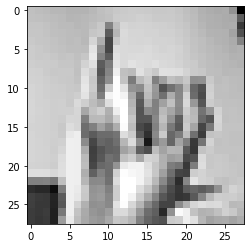

In [86]:
img, label = test_ds[10]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model1))

Label: 7 , Predicted: 7


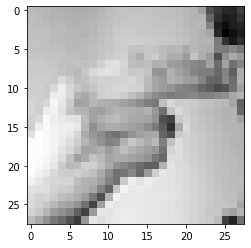

In [87]:
img, label = test_ds[200]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model1))

Label: 3 , Predicted: 3


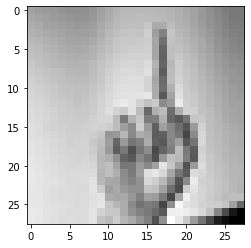

In [88]:
img, label = test_ds[1000]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model1))